### Data Analysis

### Import Packages and Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
plt.clf()

sns.set_style("whitegrid")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

<Figure size 432x288 with 0 Axes>

In [3]:
# membuat akses ke google drive untuk load data

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
url = 'https://drive.google.com/file/d/1mGiV5IeptGshP5SE6KBvjIJbimhYXxuW/view?usp=sharing'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
full_data = pd.read_csv(url, sep =',')

In [5]:
full_data

,Argumen,Kelas
0,Ada apa dengan pelecehan seksual di universita...,0
1,Ada aturan gini di kolam renang. Berarti pipis...,-1
2,"Beberapa hari belakangan ini, pemberitaan meng...",1
3,Sedang Beralangsung Diskusi Publik: Implementa...,1
4,Memang butuh wkt u/ implementasi #permendikbud...,1
...,...,...
2225,Masuknya ke uu/aturan lain yang ngatur soal ti...,1
2226,Seks bebas dan kekerasan seksual merupakan dua...,1
2227,"Setelah keluar Permendikbud no , smg tdk ada l...",-1
2228,Punya masalah apa sih orang-orang yang gak set...,1


In [6]:
full_data.describe()

,Kelas
count,2230.000000
mean,0.340359
std,0.830840
min,-1.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


### Perbandingan Jumlah Label

In [7]:
full_data['Kelas'].value_counts()

 1    1278
-1     519
 0     433
Name: Kelas, dtype: int64

In [8]:
label_neg_size = []
label_pos_size = []
label_net_size = []

for i in full_data.columns[1:]:
    label_neg_size.append(len(full_data[full_data[i]==-1]))
    label_pos_size.append(len(full_data[full_data[i]==1]))
    label_net_size.append(len(full_data[full_data[i]==0]))

In [9]:
dat_anls = pd.DataFrame({
    'label' : full_data.columns[1:],
    'positif' : label_pos_size,
    'negatif'  : label_neg_size,
    'netral' : label_net_size
})

dat_anls = dat_anls.set_index(['label'], drop=True)

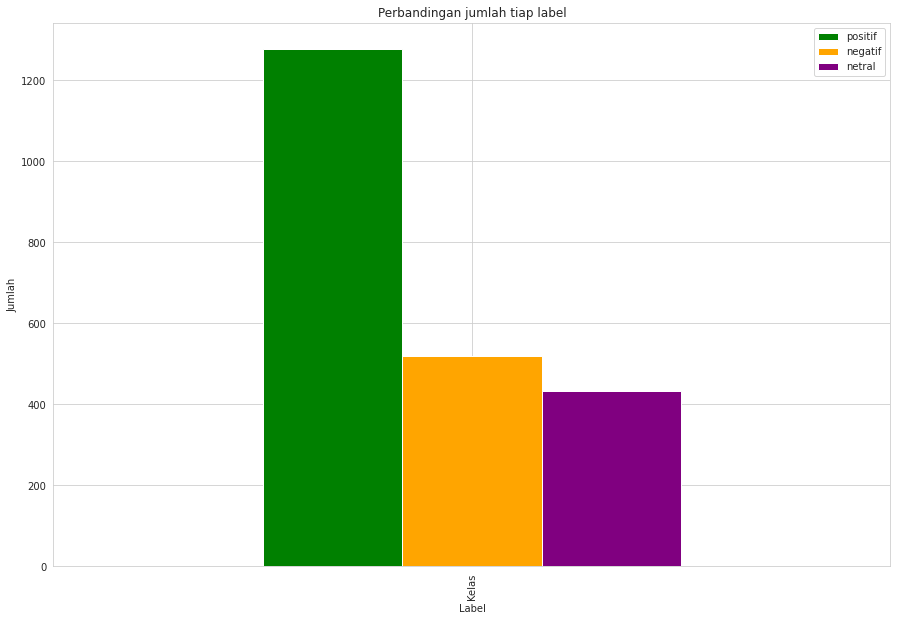

In [10]:
dat_anls.loc[:,['positif', 'negatif', 'netral']].plot.bar(color=['green','orange', 'purple'], figsize=(15,10))
plt.title("Perbandingan jumlah tiap label")
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

In [12]:
dat_anls

,positif,negatif,netral
label,,,
Kelas,1278,519,433


### Distribusi Panjang Karakter pada Argumen

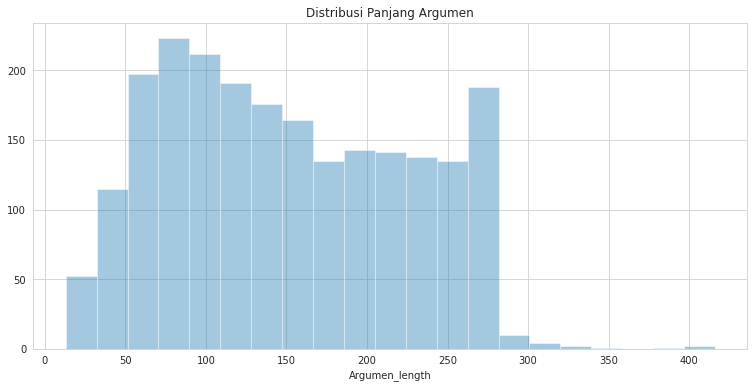

In [11]:
full_data_anl = full_data[["Argumen"]].copy()
full_data_anl['Argumen_length'] = full_data_anl['Argumen'].str.len()

plt.figure(figsize=(12.8,6))
sns.distplot(full_data_anl['Argumen_length'],kde=False).set_title('Distribusi Panjang Argumen');

In [13]:
full_data_anl.head()

,Argumen,Argumen_length
0,Ada apa dengan pelecehan seksual di universita...,61
1,Ada aturan gini di kolam renang. Berarti pipis...,88
2,"Beberapa hari belakangan ini, pemberitaan meng...",250
3,Sedang Beralangsung Diskusi Publik: Implementa...,132
4,Memang butuh wkt u/ implementasi #permendikbud...,246


In [14]:
full_data_anl['Argumen_length'].describe()

count    2230.000000
mean      150.342152
std        74.517578
min        13.000000
25%        87.000000
50%       142.000000
75%       213.000000
max       416.000000
Name: Argumen_length, dtype: float64

### Distribusi Banyak Kata pada Argumen

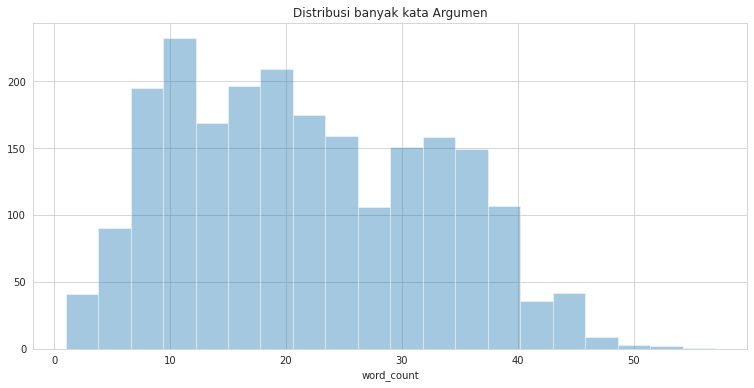

In [15]:
full_data_anl['word_count'] = full_data_anl['Argumen'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12.8,6))
sns.distplot(full_data_anl['word_count'],kde=False).set_title('Distribusi banyak kata Argumen');

In [16]:
full_data_anl.head()

,Argumen,Argumen_length,word_count
0,Ada apa dengan pelecehan seksual di universita...,61,8
1,Ada aturan gini di kolam renang. Berarti pipis...,88,14
2,"Beberapa hari belakangan ini, pemberitaan meng...",250,29
3,Sedang Beralangsung Diskusi Publik: Implementa...,132,15
4,Memang butuh wkt u/ implementasi #permendikbud...,246,37


In [17]:
full_data_anl['word_count'].describe()

count    2230.000000
mean       21.572197
std        10.950598
min         1.000000
25%        12.250000
50%        20.000000
75%        31.000000
max        57.000000
Name: word_count, dtype: float64

### Sample Argumen

In [18]:
full_data_anl['Argumen'].iloc[390]

'Knp perempuan rentan thd kekerasan seksual? Krn perlindungan lemah, sistem peradilan tdk berpihak pada korban. KUHP tdk bisa hukum pelaku, apalagi pelecehan non-fisik. #permendikbud melindungi korban, agar tdk ada kasus Baiq Nuril lagi di kampus'

In [19]:
full_data_anl['Argumen'].iloc[81]

'Logika seperti diatas sudah berlaku dan diterima sejak lama dan berpihak ke mereka yang menjadi korban yang alami kerugian dll, kenapa tidak dipakai utk kekerasan seksual,? Ini lah yang diperjuangkan mas Menteri Nadiem Makarim. #permendikbud'

### Top 20 Kata

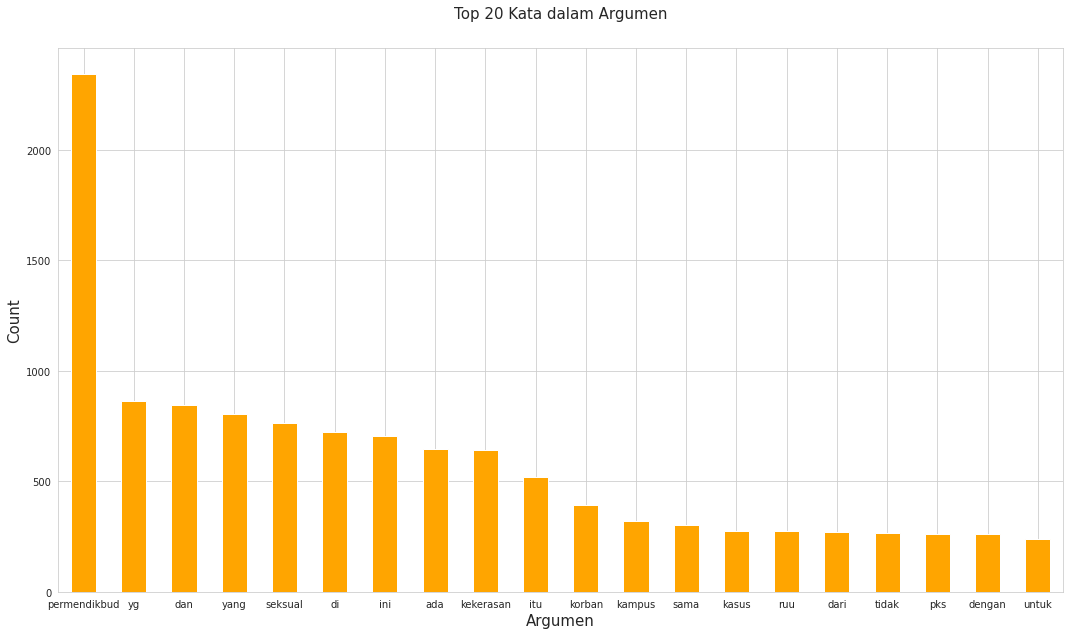

In [29]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer()
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    # print(sum_words)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(full_data_anl['Argumen'], 20)
# for word, freq in common_words:
#     print(word, freq)
topWord = pd.DataFrame(common_words, columns = ['Argumen' , 'count'])
topWord.groupby('Argumen').sum()
topWord.groupby('Argumen').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', y='Count', color='orange', title='Top 20 words in Argumen before preprocessing', figsize=(18,10));
plt.xticks(rotation = 0)
plt.title('Top 20 Kata dalam Argumen', loc = 'center', pad = 30, fontsize = 15)
plt.xlabel('Argumen', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.ylim(ymin = 0)
plt.show()

In [21]:
def total_kata(corpus):
  vect = CountVectorizer().fit(full_data_anl['Argumen'])
  bow = vect.transform(full_data_anl['Argumen'])
  sum = bow.sum(axis=0)
  # print(bow, "\n", sum)
  freq = [(word, sum[0, idx]) for word, idx in vect.vocabulary_.items()]
  return freq

In [22]:
jumlah = total_kata(full_data_anl['Argumen'])
print(len(jumlah))

6218


### Top 20 Bigram

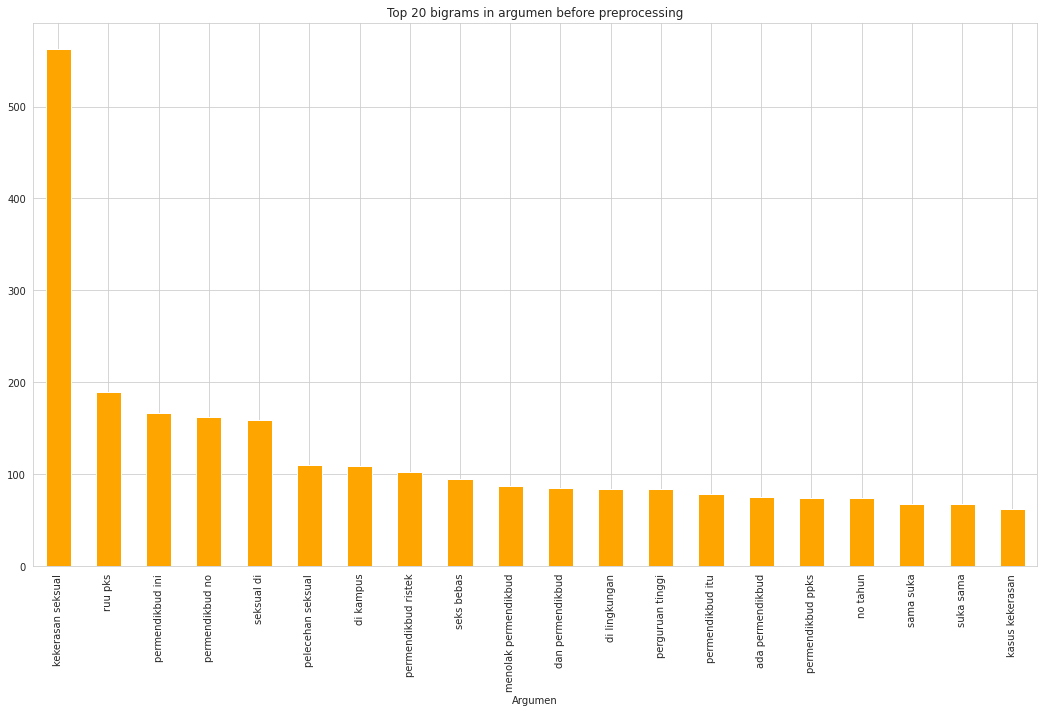

In [31]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(full_data_anl['Argumen'], 20)
# for word, freq in common_words:
#     print(word, freq)
topbigram = pd.DataFrame(common_words, columns = ['Argumen' , 'count'])
topbigram.groupby('Argumen').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', y='Count', color='orange', title='Top 20 bigrams in argumen before preprocessing', figsize=(18,10));

### Data Train Test Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(full_data['Argumen'], full_data['Kelas'], stratify=full_data['Kelas'], test_size=0.3)

In [25]:
data_train = pd.DataFrame({
    'Argumen' : X_train,
    'Kelas'  : y_train
})

In [26]:
data_test = pd.DataFrame({
    'Argumen' : X_test,
    'Kelas'  : y_test
})

In [27]:
data_train.to_csv('/content/drive/MyDrive/TA_MEIRA REYNITA PUTRI_1301164695/Code/Data/data_train_70_30_1.csv', index=False)
data_test.to_csv('/content/drive/MyDrive/TA_MEIRA REYNITA PUTRI_1301164695/Code/Data/data_test_70_30_1.csv', index=False)